In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import threading

from keras import backend as K
from keras import losses
from keras.callbacks import Callback, LearningRateScheduler
from keras.layers import Lambda, Dense, Input, concatenate, Activation, Conv3D, MaxPool3D, AvgPool3D, BatchNormalization, Flatten, Dropout, GlobalAveragePooling3D
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import Iterator, ImageDataGenerator
from keras.utils.data_utils import Sequence
from skimage import img_as_float, io
from skimage.transform import resize

Using TensorFlow backend.


# Prepare Data

In [2]:
TRAIN = './data/images_training_rev1/'
TEST = './data/images_test_rev1/'
LABELS = './data/training_solutions_rev1.csv'

In [3]:
files = sorted(os.listdir(TRAIN))
train_files = files[6000:]
val_files = files[:6000]
test_files = sorted(os.listdir(TEST))

print(len(train_files))
print(len(val_files))
print(len(test_files))

55578
6000
79975


In [4]:
train_labels = pd.read_csv(LABELS).set_index('GalaxyID').T.to_dict('list')
print(len(train_labels))

61578


# Construct Model

In [7]:
def DenseLayer(inputs, k, bn=None, drop=None):
    x = BatchNormalization()(inputs)
    if bn: # Bottleneck
        x = Activation('relu')(x)
        x = Conv3D(k*bn, (1,1,1))(x)
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(k, (1,3,3), padding='same')(x)
    if drop:
        x = Dropout(drop)(x)
    return concatenate([inputs, x], axis=4)

def DenseBlock(x, k, L, bn=None, drop=None):
    for l in range(L):
        x = DenseLayer(x, k, bn, drop)
    return x

def TransitionLayer(x, k):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(k, (1,1,1))(x)
    x = AvgPool3D((1,2,2), strides=(1,2,2), padding='same')(x)
    return x
    
def DenseNet(shape, k, bn, theta, drop, B, L, outs):
    img_input = Input(shape=(4,shape,shape,3))
    x = Conv3D(k*2, (1,7,7), strides=(1,2,2), padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool3D((1,3,3), strides=(1,2,2), padding='same')(x)
    for i in range(B):
        x = DenseBlock(x, k, L, bn, drop)
        if i != B-1:
            k = int(k*theta) # compression
            x = TransitionLayer(x, k)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv3D(37, (1,7,7))(x)
    x = GlobalAveragePooling3D()(x)
    x = Activation('sigmoid')(x)
    return Model(inputs=img_input, outputs=x)

In [8]:
IMAGE_SIZE = 112
model = DenseNet(IMAGE_SIZE, k=40, bn=None, theta=0.5, drop=None, B=3, L=4, outs=37)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 4, 112, 112, 3 0                                            
____________________________________________________________________________________________________
conv3d_17 (Conv3D)               (None, 4, 56, 56, 80) 11840       input_2[0][0]                    
____________________________________________________________________________________________________
batch_normalization_17 (BatchNor (None, 4, 56, 56, 80) 320         conv3d_17[0][0]                  
____________________________________________________________________________________________________
activation_18 (Activation)       (None, 4, 56, 56, 80) 0           batch_normalization_17[0][0]     
___________________________________________________________________________________________

# Build Data Generator

In [17]:
class StandardIterator(Iterator):
    def __init__(self, primary_dir, primary_files, labels=None,
                 batch_size=64, shuffle=True, seed=None,
                 secondary_dir=None, secondary_files=None):
        self.primary_dir = primary_dir
        self.file_names = primary_files + secondary_files if secondary_files else primary_files
        self.boundary = len(primary_files)
        self.secondary_dir = secondary_dir
        self.labels = labels
        super(StandardIterator, self).__init__(len(self.file_names), batch_size, shuffle, seed)
    
    def update(self, labels):
        with self.lock:
            self.labels = labels
    
    def next(self):
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
            batch_x = np.zeros((current_batch_size,4,IMAGE_SIZE,IMAGE_SIZE,3), dtype=K.floatx())
            batch_y = np.zeros((current_batch_size,37), dtype=K.floatx()) if self.labels else None
        
        for i, j in enumerate(index_array):
            is_primary = j < self.boundary
            fname = self.file_names[j]
            file_dir = self.primary_dir if is_primary else self.secondary_dir
            fpath = os.path.join(file_dir, fname)
            img = io.imread(fpath)
            img = img[70:-70,70:-70]
            img = resize(img, (IMAGE_SIZE,IMAGE_SIZE), mode='reflect')
            x = img_as_float(img)
            arrs = [np.rot90(x, a) for a in range(4)]
            x = np.stack(arrs,0)
            batch_x[i] = x
            if not (batch_y is None):
                batch_y[i] = np.reshape(self.labels[int(fname[:-4])], (-1,37))
        return (batch_x, batch_y) if (not (batch_y is None)) else batch_x

In [18]:
class MixedIterator(object):
    def __init__(self, train_dir, train_files, validation_files,
                 test_dir, test_files, train_labels, batch_split):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.train_files = train_files
        self.validation_files = validation_files
        self.test_files = test_files
        self.train_labels = train_labels
        self.pseudo_labels = {}
        self.train_gen = StandardIterator(train_dir, train_files, train_labels, batch_size=batch_split[0])
        self.pseudo_gen = StandardIterator(train_dir, validation_files, batch_size=batch_split[1],
                                           secondary_dir=self.test_dir, secondary_files=self.test_files)
        self.lock = threading.Lock()
    
    def reset(self):
        self.train_gen.reset()
        self.pseudo_gen.reset()
        
    def get_pseudo_labels(self):
        return self.pseudo_labels
    
    def update(self, model):
        with self.lock:
            pred_gen = StandardIterator(self.train_dir, self.validation_files, shuffle=False, batch_size=60)
            new_labels = model.predict_generator(pred_gen, len(self.validation_files)//60, verbose=1)
            for i, j in enumerate(self.validation_files):
                name = int(j[:-4])
                self.pseudo_labels[name] = new_labels[i,:]
            pred_gen = StandardIterator(self.test_dir, self.test_files, shuffle=False, batch_size=35)
            new_labels = model.predict_generator(pred_gen, len(self.test_files)//35, verbose=1)
            for i, j in enumerate(self.test_files):
                name = int(j[:-4])
                self.pseudo_labels[name] = new_labels[i,:]
            self.pseudo_gen.update(self.pseudo_labels)
            
    def __next__(self):
        return self.next()
    
    def next(self):
        with self.lock:
            a = next(self.train_gen)
            if len(self.pseudo_labels) > 0:
                b = next(self.pseudo_gen)
                return (np.concatenate((a[0],b[0])), np.concatenate((a[1],b[1])))
            else:
                return a

# Train Model

In [19]:
def rmse(y_true, y_pred):
    return K.sqrt(losses.mean_squared_error(y_true, y_pred))

In [21]:
BATCH_SIZE = 32
TRAIN_BATCH_SIZE = 22
PSEUDO_BATCH_SIZE = BATCH_SIZE - TRAIN_BATCH_SIZE

train_generator = StandardIterator(TRAIN, train_files, train_labels, batch_size=BATCH_SIZE)
pseudo_generator = MixedIterator(TRAIN, train_files, val_files, TEST, test_files, train_labels,
                                 batch_split=(TRAIN_BATCH_SIZE, PSEUDO_BATCH_SIZE))
val_generator = StandardIterator(TRAIN, val_files, train_labels, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
model.compile(optimizer=Adam(0.001), loss=rmse)
training_progress = model.fit_generator(train_generator,
                        steps_per_epoch=len(train_files)//BATCH_SIZE,
                        epochs=30,
                        validation_data=val_generator,
                        validation_steps=len(val_files)//BATCH_SIZE,
                        max_queue_size=10)

Epoch 1/30
1736/1736 [==============================] - 404s - loss: 0.0955 - val_loss: 0.1143
Epoch 2/30
1736/1736 [==============================] - 402s - loss: 0.0916 - val_loss: 0.1265
Epoch 3/30
1736/1736 [==============================] - 401s - loss: 0.0894 - val_loss: 0.0955
Epoch 4/30
1736/1736 [==============================] - 403s - loss: 0.0873 - val_loss: 0.0909
Epoch 5/30
1736/1736 [==============================] - 401s - loss: 0.0861 - val_loss: 0.0891
Epoch 6/30
1736/1736 [==============================] - 401s - loss: 0.0847 - val_loss: 0.0908
Epoch 7/30
1736/1736 [==============================] - 401s - loss: 0.0837 - val_loss: 0.0909
Epoch 8/30
1736/1736 [==============================] - 401s - loss: 0.0826 - val_loss: 0.0856
Epoch 9/30
1736/1736 [==============================] - 402s - loss: 0.0817 - val_loss: 0.0854
Epoch 10/30
1736/1736 [==============================] - 400s - loss: 0.0810 - val_loss: 0.0883
Epoch 11/30
1736/1736 [==========================

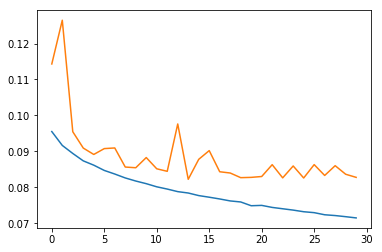

In [24]:
plt.plot(training_progress.epoch, training_progress.history['loss'], label='Train')
plt.plot(training_progress.epoch, training_progress.history['val_loss'], label='Validation')

In [25]:
pseudo_generator.update(model)
training_progress = model.fit_generator(pseudo_generator,
                        steps_per_epoch=len(train_files)//TRAIN_BATCH_SIZE,
                        epochs=5,
                        validation_data=val_generator,
                        validation_steps=len(val_files)//BATCH_SIZE,
                        max_queue_size=10)

2285/2285 [==============================] - 479s   
Epoch 1/5
2526/2526 [==============================] - 570s - loss: 0.0566 - val_loss: 0.0829
Epoch 2/5
2526/2526 [==============================] - 569s - loss: 0.0564 - val_loss: 0.0848
Epoch 3/5
2526/2526 [==============================] - 568s - loss: 0.0561 - val_loss: 0.0886
Epoch 4/5
2526/2526 [==============================] - 568s - loss: 0.0560 - val_loss: 0.0819
Epoch 5/5
2526/2526 [==============================] - 569s - loss: 0.0557 - val_loss: 0.0915


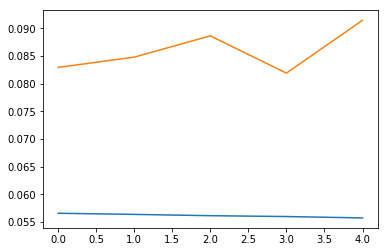

In [26]:
plt.plot(training_progress.epoch, training_progress.history['loss'], label='Train')
plt.plot(training_progress.epoch, training_progress.history['val_loss'], label='Validation')

In [27]:
model.compile(optimizer=Adam(0.0001), loss=rmse)
training_progress = model.fit_generator(train_generator,
                        steps_per_epoch=len(train_files)//BATCH_SIZE,
                        epochs=10,
                        validation_data=val_generator,
                        validation_steps=len(val_files)//BATCH_SIZE,
                        max_queue_size=10)

Epoch 1/10
1736/1736 [==============================] - 403s - loss: 0.0668 - val_loss: 0.0808
Epoch 2/10
1736/1736 [==============================] - 403s - loss: 0.0657 - val_loss: 0.0810
Epoch 3/10
1736/1736 [==============================] - 402s - loss: 0.0653 - val_loss: 0.0809
Epoch 4/10
1736/1736 [==============================] - 403s - loss: 0.0651 - val_loss: 0.0809
Epoch 5/10
1736/1736 [==============================] - 402s - loss: 0.0648 - val_loss: 0.0810
Epoch 6/10
1736/1736 [==============================] - 402s - loss: 0.0646 - val_loss: 0.0811
Epoch 7/10
1736/1736 [==============================] - 401s - loss: 0.0645 - val_loss: 0.0812
Epoch 8/10
1736/1736 [==============================] - 402s - loss: 0.0643 - val_loss: 0.0813
Epoch 9/10
1736/1736 [==============================] - 401s - loss: 0.0641 - val_loss: 0.0813
Epoch 10/10
1736/1736 [==============================] - 403s - loss: 0.0641 - val_loss: 0.0818


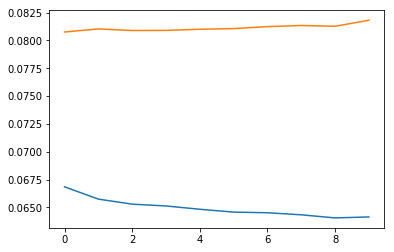

In [28]:
plt.plot(training_progress.epoch, training_progress.history['loss'], label='Train')
plt.plot(training_progress.epoch, training_progress.history['val_loss'], label='Validation')

In [29]:
pseudo_generator.reset()
pseudo_generator.update(model)
training_progress = model.fit_generator(pseudo_generator,
                        steps_per_epoch=len(train_files)//TRAIN_BATCH_SIZE,
                        epochs=5,
                        validation_data=val_generator,
                        validation_steps=len(val_files)//BATCH_SIZE,
                        max_queue_size=10)

2285/2285 [==============================] - 443s   
Epoch 1/5
2526/2526 [==============================] - 569s - loss: 0.0478 - val_loss: 0.0819
Epoch 2/5
2526/2526 [==============================] - 569s - loss: 0.0477 - val_loss: 0.0819
Epoch 3/5
2526/2526 [==============================] - 569s - loss: 0.0476 - val_loss: 0.0817
Epoch 4/5
2526/2526 [==============================] - 570s - loss: 0.0476 - val_loss: 0.0815
Epoch 5/5
2526/2526 [==============================] - 569s - loss: 0.0475 - val_loss: 0.0818


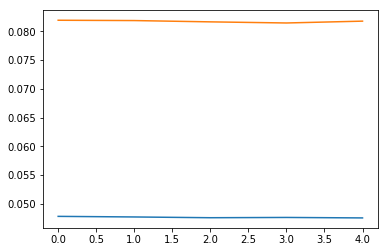

In [30]:
plt.plot(training_progress.epoch, training_progress.history['loss'], label='Train')
plt.plot(training_progress.epoch, training_progress.history['val_loss'], label='Validation')

# Predict Outputs

In [ ]:
test_size = len(test_files)
preds = model.predict_generator(StandardIterator(TEST, test_files, batch_size=35, shuffle=False), steps=test_size//35, verbose=1)

In [ ]:
train_headers = pd.read_csv(LABELS)

files2 = sorted(os.listdir(TEST))
files2 = list(map(lambda x: int(x[:-4]), files2))

outputcsv = pd.DataFrame(data=np.c_[files2, preds],
                         index=np.arange(len(files2)),
                         columns=train_headers.columns)
outputcsv[['GalaxyID']] = outputcsv[['GalaxyID']].astype(int)
outputcsv.to_csv('./predictions.csv', index=False)